In [1]:
import argparse
import csv
import os
import tqdm
import pdb
import shutil
import time
import torch
import numpy as np
import torchvision
import torch.nn as nn
import os.path as osp
import torch.optim as optim
from torchvision import datasets, models
from functools import partial
import torchvision.models as models
import torch.optim as optim
from torch.autograd import Variable
from torch.backends import cudnn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,precision_recall_fscore_support


C:\Users\HIREE\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HIREE\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
#model=Pre_ResNet18Model1(num_classes=5)
#model=my_InceptionV3(num_classes=5)
model=resnet18_ccsam(num_classes=5)
#model=ccsam_inception_v3(num_classes=5)
#model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)
#model = model.cuda()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ccsam): CCSAM(
        (channel_attention): ChannelAttention(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (max_pool): AdaptiveMaxPool2d(output_size=1)
          (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bia

In [3]:
# get the number of model parameters
print('Total Number of model parameters: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print("Number of trainable parameters:", num_trainable_params)
print("Number of non-trainable parameters:", num_non_trainable_params)


Total Number of model parameters: 11396957
Number of trainable parameters: 11396957
Number of non-trainable parameters: 0


In [4]:
!python DataPreProccessing_1GA.py

In [5]:
# Data loading

train_loader,valid_loader, TestLoader = DataPreProccessing_1GA.preproccessing()
# Define the class labels
class_labels = ['FMD', 'KCD', 'LD', 'RWD', 'WD']


Total Number of training and validation images processing per batches: 7854
Total Number of training images processing per batches: 884 99
Total Number of images in Testing folder: 2130


In [6]:
#For this example, we'll be using a cross-entropy loss. For demonstration purposes, we'll create batches of dummy output and label values, run them through the loss function, and examine the result.
#criterion = nn.CrossEntropyLoss().cuda()
# NB: Loss functions expect data in batches, so we're creating batches of 5
# Represents the model's confidence in each of the 5 classes for a given input
#dummy_outputs = torch.rand(4, 5)
# Represents the correct class among the 5 being tested
#class_labels = torch.tensor([1, 2, 3,4])
    
#print(dummy_outputs)
#print(class_labels)

#loss = criterion(dummy_outputs, class_labels)
#print('Total loss for this batch: {}'.format(loss.item()))

In [7]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)

In [8]:
# Set up tensorboard writer
# Initializing in a separate cell so we can easily add more epochs to the same run
#filename = 'Pre_ResNet18Model1'
#filename = 'my_InceptionV3'
filename = 'resnet18_ccsam'
#filename = 'ccsam_inception_v3'
#filename = 'Freezing_layer_Resnet18WithCCSAM1'
log_dir = 'E:/jupyter notebook/last_code_model/Results_log/logsOf_first_GA/'
saved_model_path='E:/jupyter notebook/last_code_model/saved_model_code/'
writer = SummaryWriter(log_dir + filename)


In [ ]:
import matplotlib.pyplot as plt
best_vloss = 0.7

epoch_number=50
# calculate validation loss and accuracy
val_loss = 0.0
val_correct = 0
val_total = 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies=[]
for epoch in range(epoch_number):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
         # calculate training loss
        avg_trainLoss=running_loss / len(train_loader.dataset)
        avg_trainAccuracy= 100 * correct / total
    model.eval()
    #num_batches = 0
    with torch.no_grad():
        for i,data in enumerate(valid_loader):
            images, labels = data
            outputs = model(images)
            val_loss += criterion(outputs, labels).item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
        avg_valLoss = val_loss / val_total
        avg_Val_Accuracy = 100 * val_correct / (val_total+1)
        train_losses.append(loss.item())
        val_losses.append(avg_valLoss)
        train_accuracies.append(avg_trainAccuracy)
        val_accuracies.append(avg_Val_Accuracy)
   # Log the running loss averaged per batch
    # for both training and validation
        global_step = epoch * len(train_loader) + i
        writer.add_scalars('loss', {'Training Loss': loss.item(),
                                    'Validation Loss': avg_valLoss}, epoch)
        writer.add_scalars('Accuracy', {'Training Accuracy': avg_trainAccuracy,
                                    'Validation Accuracy': avg_Val_Accuracy}, epoch)
        
        #Close tensorboard writer
        writer.close()
    print('Epoch %d: Training Loss: %.3f -- Training Accuracy: %.3f%%  -- Validation Loss: %.3f  -- Validation Accuracy: %.3f%%' %
          (epoch + 1, avg_trainLoss, avg_trainAccuracy, avg_valLoss, avg_Val_Accuracy))
    
    
    
    

    # Track best performance, and save the model's state
    if avg_valLoss < best_vloss:
        best_vloss = avg_valLoss
        model_path = os.path.join(saved_model_path, filename + '.pth')
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# Plot the training and validation accuracy
plt.plot(train_accuracies, label='train_Accuracy')
plt.plot(val_accuracies, label='val_Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(frameon=False)
plt.show()
plt.plot(train_accuracies, label='train_Accuracy')
plt.plot(val_accuracies, label='val_Accuracy')
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.ylabel('accuracy vs loss')
plt.xlabel('Epoch')
plt.legend(frameon=False)
plt.show()

Epoch 1: Training Loss: 0.271 -- Training Accuracy: 35.144%  -- Validation Loss: 1.422  -- Validation Accuracy: 45.235%
Epoch 2: Training Loss: 0.172 -- Training Accuracy: 44.581%  -- Validation Loss: 1.331  -- Validation Accuracy: 47.552%
Epoch 3: Training Loss: 0.153 -- Training Accuracy: 52.080%  -- Validation Loss: 1.243  -- Validation Accuracy: 51.971%
Epoch 4: Training Loss: 0.132 -- Training Accuracy: 60.385%  -- Validation Loss: 1.148  -- Validation Accuracy: 56.025%
Epoch 5: Training Loss: 0.110 -- Training Accuracy: 68.322%  -- Validation Loss: 1.084  -- Validation Accuracy: 58.764%
Epoch 6: Training Loss: 0.091 -- Training Accuracy: 73.642%  -- Validation Loss: 0.984  -- Validation Accuracy: 62.815%
Epoch 7: Training Loss: 0.075 -- Training Accuracy: 78.919%  -- Validation Loss: 0.900  -- Validation Accuracy: 66.200%
Epoch 8: Training Loss: 0.064 -- Training Accuracy: 81.904%  -- Validation Loss: 0.834  -- Validation Accuracy: 68.787%
Epoch 9: Training Loss: 0.052 -- Trainin

Test Accuracy: 99.34
Confusion matrix:
[[ 99.6          0.           0.           0.2          0.2       ]
 [  0.         100.           0.           0.           0.        ]
 [  0.           0.22321429  99.77678571   0.           0.        ]
 [  0.           0.25         0.          98.5          1.25      ]
 [  0.33112583   0.           0.           1.32450331  98.34437086]]


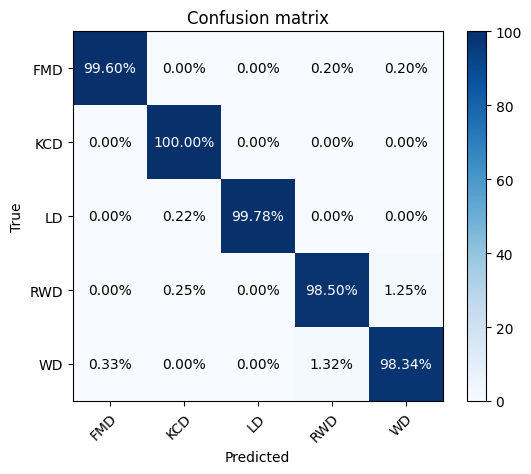

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       500
         1.0       1.00      1.00      1.00       480
         2.0       1.00      1.00      1.00       448
         3.0       0.99      0.98      0.99       400
         4.0       0.98      0.98      0.98       302

    accuracy                           0.99      2130
   macro avg       0.99      0.99      0.99      2130
weighted avg       0.99      0.99      0.99      2130



In [9]:

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,precision_recall_fscore_support

model_path ='E:/jupyter notebook/last_code_model/saved_model_code/resnet18_ccsam.pth'
# Load saved model
model.load_state_dict(torch.load(model_path))

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in TestLoader:
        data=data 
        labels =  labels
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}")

# Load saved model
model.load_state_dict(torch.load(model_path))

# Set model to evaluation mode
model.eval()

# Define empty arrays for storing true labels and predicted labels
true_labels = np.array([])
pred_labels = np.array([])

# Define empty arrays for storing loss and accuracy
loss_list = []
accuracy_list = []

# Evaluate model on test set
model.eval()
with torch.no_grad():
    for data, labels in TestLoader:
        data = data
        labels = labels

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Get predictions and calculate accuracy
        _, preds = torch.max(outputs, 1)
        true_labels = np.append(true_labels, labels.cpu().numpy())
        pred_labels = np.append(pred_labels, preds.cpu().numpy())
        accuracy = accuracy_score(true_labels, pred_labels) * 100
        accuracy_list.append(accuracy)


# Create confusion matrix
conf_mat = confusion_matrix(true_labels, pred_labels)
# Normalize confusion matrix to percentages
conf_mat_pct = 100 * conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Print confusion matrix
print('Confusion matrix:')
print(conf_mat_pct)

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(conf_mat_pct, cmap='Blues')

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Set axis labels
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Loop over data dimensions and create text annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        ax.text(j, i, format(conf_mat_pct[i, j], '.2f') + '%',
                ha='center', va='center', color='white' if conf_mat[i, j] > conf_mat.max() / 2 else 'black')

# Set title
ax.set_title('Confusion matrix')

# Show plot
plt.show()
# classification report
print(classification_report(true_labels, pred_labels))

# accuracy score
acc = accuracy_score(true_labels, pred_labels)

# precision, recall, f1-score, support
precision, recall, f1score, support = precision_recall_fscore_support(true_labels, pred_labels)

In [14]:


model_path = os.path.join(saved_model_path, filename + '.pth')
# Load saved model
model.load_state_dict(torch.load(model_path))


model.eval()

# Load single test image and preprocess it
from PIL import Image
import torchvision.transforms as transforms

img_path = "C:/Users/yared/Desktop/hashim file/Research Data/processed_10000_kan_sirrii_SecondGA_my/test/Foot_mouth_disease/FMD11 (34).jpg"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

img = Image.open(img_path)
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0) # add batch dimension

# Test model on single image
with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = torch.max(outputs.data, 1)

print('Predicted class: ', predicted.item())

Predicted class:  0


In [25]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import cv2
from torchvision.models import ResNet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the pre-trained RESNET18 model with CBAM attention mechanism
model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
#model.fc = torch.nn.Identity()
#model.fc2 = torch.nn.Identity()
#model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)

# Load the ResNet18 model
#model = models.resnet18(pretrained=True)
#model.eval()
# Load the pre-trained ResNet50 model
#model=Pre_ResNet18Model1(num_classes=5)
model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = "E:/jupyter notebook/my_trying_fie/All_In_One/DatasetContainer/Processed_10000_FirstGA_other/test/FMD/FMD_0_3215.jpg"
#image_path = "E:/jupyter notebook/my_trying_fie/All_In_One/DatasetContainer/Processed_10000_FirstGA_other/test/KCD/KCJ18.jpg"
#image_path = "E:/jupyter notebook/my_trying_fie/All_In_One/DatasetContainer/Processed_10000_FirstGA_other/test/LD/LD (24).jpg"
#image_path = "E:/jupyter notebook/my_trying_fie/All_In_One/DatasetContainer/Processed_10000_FirstGA_other/test/RWD/RD (1)_0_9520.jpg"
#image_path = "E:/jupyter notebook/my_trying_fie/All_In_One/DatasetContainer/Processed_10000_FirstGA_other/test/WD/WD1 (5).jpg"
image = Image.open(image_path).convert('RGB')
# Preprocess the image

input_tensor = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(input_tensor)
pred_label = torch.argmax(output, dim=1).item()

# Get the gradients with respect to the input tensor
model.zero_grad()
output[:, pred_label].backward()

# Get the gradients from the model's first convolutional layer
gradients = model.conv1.weight.grad

# Average the gradients across the RGB channels
pooled_gradients = torch.mean(gradients, dim=[2, 3])

# Get the feature maps from the last convolutional layer
features = model.layer4(input_tensor)

feature_hook = model.register_forward_hook(features)
gradient_hook = model.register_backward_hook(pooled_gradients)
# Multiply the feature maps by the corresponding gradients
for i in range(features.size(0)):
    features[:, i, :, :] *= pooled_gradients[0, i]

# Sum the feature maps along the channels dimension
heatmap = torch.sum(features, dim=1).squeeze()

# Normalize the heat map values
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heat map to a numpy array
heatmap = heatmap.detach().numpy()
feature_hook.remove()
gradient_hook.remove()
# Visualize the heat map
#plt.imshow('Original Image', image)
#plt.imshow(heatmap, cmap='jet')
#plt.axis('off')
#plt.show()

# Apply the attention map to the original image
#heatmap = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)

# Display the original image, attention map, and superimposed image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title('Resnet18')
ax[1].axis('off')


plt.tight_layout()
plt.show()



RuntimeError: Given groups=1, weight of size [512, 256, 3, 3], expected input[1, 3, 224, 224] to have 256 channels, but got 3 channels instead

In [148]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2

# Load the pre-trained RESNET18 model with CBAM attention mechanism
model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
model.fc = torch.nn.Identity()
model.fc2 = torch.nn.Identity()
# Set the model to evaluation mode
model.eval()

# Define the transform to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image_path = 'E:/jupyter notebook/my_trying_fie/All_In_One/DatasetContainer/Processed_10000_FirstGA_other/test/FMD/FMD_0_4290.jpg'
image = Image.open(image_path).convert('RGB')
# Preprocess the image
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

# Forward pass through the model
output = model(input_batch)

# Get the activation maps from the last convolutional layer
activation_maps = model.layer4[-1].conv2(output)
activation_maps = activation_maps.unsqueeze()
# Convert the activation maps to numpy array
activation_maps = activation_maps.detach().cpu().numpy()

# Calculate the mean across the channel dimension
mean_activation_map = np.mean(activation_maps, axis=1)

# Normalize the mean activation map between 0 and 1
mean_activation_map = (mean_activation_map - np.min(mean_activation_map)) / (
    np.max(mean_activation_map) - np.min(mean_activation_map)
)

# Resize the mean activation map to match the image size
mean_activation_map = cv2.resize(
    mean_activation_map, (image.size[0], image.size[1])
)

# Apply the mean activation map as the kernel activation map
kernel_activation_map = mean_activation_map

# Convert the image to numpy array
image = np.array(image)

# Scale the kernel activation map to the range of 0 to 255
kernel_activation_map = cv2.convertScaleAbs(
    kernel_activation_map * 255
)

# Apply the kernel activation map to the image
heatmap = cv2.applyColorMap(
    kernel_activation_map, cv2.COLORMAP_JET
)

# Superimpose the kernel activation map on the image
superimposed_img = cv2.addWeighted(
    image, 0.6, heatmap, 0.4, 0
)

# Display the original image, kernel activation map, and the superimposed image
cv2.imshow('Original Image', image)
cv2.imshow('Kernel Activation Map', kernel_activation_map)
cv2.imshow('Superimposed Image', superimposed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()





RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 512]

In [18]:
#model=Pre_ResNet18Model1(num_classes=5)
#model=my_InceptionV3(num_classes=5)
model=resnet18_ccsam(num_classes=5)
#model=ccsam_inception_v3(num_classes=5)
#model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)
#model = model.cuda()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ccsam): CCSAM(
        (channel_attention): ChannelAttention(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (max_pool): AdaptiveMaxPool2d(output_size=1)
          (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bia

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from model.ccsam_module import CCSAM
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the ResNet-18 model to include CBAM
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Linear(512, 10)  # Modify the last fully connected layer for your task
model.layer1[-1].relu = CCSAM(64)
model.layer2[-1].relu = CCSAM(128)
model.layer3[-1].relu = CCSAM(256)
model.layer4[-1].relu = CCSAM(512)
# Define the Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradient = None
        self.activations = None

        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        target_layer = self.target_layer
        for name, module in self.model.named_modules():
            if name == target_layer:
                module.register_backward_hook(backward_hook)
                module.register_forward_hook(forward_hook)

    def forward(self, x):
        return self.model(x)

    def backward(self, index=None):
        if index is None:
            index = torch.argmax(self.output)

        # Calculate the sum of self.output for scalar output
        sum_output = self.output.sum()
        sum_output.backward(retain_graph=True)

    def generate_heatmap(self, input_image, target_class=None):
       
        # Forward pass through the model
        self.output = self.forward(input_image)
        pred_label = torch.argmax(self.output, dim=1).item()

        # Get the gradients with respect to the input tensor
        self.model.zero_grad()
        self.output[:, pred_label].backward()

        # Get the gradients from the model's first convolutional layer
        gradients = self.model.conv1.weight.grad

        # Average the gradients across the RGB channels
        pooled_gradients = torch.mean(gradients, dim=[2, 3])

        # Get the feature maps from the last convolutional layer
        features = self.model.layer4(input_image)

        # Multiply the feature maps by the corresponding gradients
        for i in range(features.size(0)):
            features[:, i, :, :] *= pooled_gradients[0, i]

        # Sum the feature maps along the channels dimension
        heatmap = torch.sum(features, dim=1).squeeze()

        # Normalize the heat map values
        heatmap = nn.functional.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.squeeze().detach().numpy()


# Load the image and preprocess
image_path = 'E:/jupyter notebook/my_trying_fie/All_In_One/DatasetContainer/Processed_10000_FirstGA_other/test/FMD/FMD_0_4290.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = preprocess(image).unsqueeze(0)

# Initialize the Grad-CAM object
grad_cam = GradCAM(model, target_layer='layer4')

# Choose the target class index
target_class_index = 5  # Replace with the target class index for visualization

# Generate the heatmap
heatmap = grad_cam.generate_heatmap(input_image, target_class=target_class_index)

# Resize the heatmap to match the input image size
heatmap = np.uint8(heatmap * 255)
heatmap = np.uint8(Image.fromarray(heatmap).resize((224, 224), Image.BILINEAR))

# Resize the input image to match the heatmap size
resized_image = image.resize((224, 224))

# Apply the heatmap on the input image
heatmap_expanded = np.expand_dims(heatmap, axis=2)  # Expand the dimensions of the heatmap
blended_image = np.float32(resized_image) + np.float32(heatmap_expanded)
blended_image /= np.max(blended_image)

# Plot the heatmap overlay and the original image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(resized_image)
ax1.axis('off')
ax1.set_title('Original Image')

ax2.imshow(blended_image)
ax2.axis('off')
ax2.set_title('Heatmap Overlay')

plt.tight_layout()
plt.show()


RuntimeError: Given groups=1, weight of size [512, 256, 3, 3], expected input[1, 3, 224, 224] to have 256 channels, but got 3 channels instead